#### save data -> .npy -> load

In [2]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os

train_path = './mnist_image_label/mnist_train_jpg_60000/'
train_txt = './mnist_image_label/mnist_train_jpg_60000.txt'
x_train_savepath = './mnist_image_label/mnist_x_train.npy'
y_train_savepath = './mnist_image_label/mnist_y_train.npy'

test_path = './mnist_image_label/mnist_test_jpg_10000/'
test_txt = './mnist_image_label/mnist_test_jpg_10000.txt'
x_test_savepath = './mnist_image_label/mnist_x_test.npy'
y_test_savepath = './mnist_image_label/mnist_y_test.npy'


def generateds(path, txt):
    f = open(txt, 'r')  # 以只读形式打开txt文件
    contents = f.readlines()  # 读取文件中所有行
    f.close()  # 关闭txt文件
    x, y_ = [], []  # 建立空列表
    for content in contents:  # 逐行取出
        value = content.split()  # 以空格分开，图片路径为value[0] , 标签为value[1] , 存入列表
        img_path = path + value[0]  # 拼出图片路径和文件名
        img = Image.open(img_path)  # 读入图片
        img = np.array(img.convert('L'))  # 图片变为8位宽灰度值的np.array格式
        img = img / 255.  # 数据归一化 （实现预处理）
        x.append(img)  # 归一化后的数据，贴到列表x
        y_.append(value[1])  # 标签贴到列表y_
        print('loading : ' + content)  # 打印状态提示

    x = np.array(x)  # 变为np.array格式
    y_ = np.array(y_)  # 变为np.array格式
    y_ = y_.astype(np.int64)  # 变为64位整型
    return x, y_  # 返回输入特征x，返回标签y_


if os.path.exists(x_train_savepath) and os.path.exists(y_train_savepath) and os.path.exists(
        x_test_savepath) and os.path.exists(y_test_savepath):
    print('-------------Load Datasets-----------------')
    x_train_save = np.load(x_train_savepath)
    y_train = np.load(y_train_savepath)
    x_test_save = np.load(x_test_savepath)
    y_test = np.load(y_test_savepath)
    x_train = np.reshape(x_train_save, (len(x_train_save), 28, 28))
    x_test = np.reshape(x_test_save, (len(x_test_save), 28, 28))
else:
    print('-------------Generate Datasets-----------------')
    x_train, y_train = generateds(train_path, train_txt)
    x_test, y_test = generateds(test_path, test_txt)

    print('-------------Save Datasets-----------------')
    x_train_save = np.reshape(x_train, (len(x_train), -1))
    x_test_save = np.reshape(x_test, (len(x_test), -1))
    np.save(x_train_savepath, x_train_save)
    np.save(y_train_savepath, y_train)
    np.save(x_test_savepath, x_test_save)
    np.save(y_test_savepath, y_test)

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test), validation_freq=1)
model.summary()


-------------Load Datasets-----------------
Epoch 1/2


2022-11-01 22:25:11.430548: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1870/1875 [============================>.] - ETA: 0s - loss: 0.2655 - sparse_categorical_accuracy: 0.9232

2022-11-01 22:25:18.570006: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


1875/1875 [==============================] - 8s 4ms/step - loss: 0.2651 - sparse_categorical_accuracy: 0.9233 - val_loss: 0.1472 - val_sparse_categorical_accuracy: 0.9573
Epoch 2/2
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1201 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.1043 - val_sparse_categorical_accuracy: 0.9686
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
__________________________

#### enforce

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  # 给数据增加一个维度,从(60000, 28, 28)reshape为(60000, 28, 28, 1)

image_gen_train = ImageDataGenerator(
    rescale=1. / 1.,  # 如为图像，分母为255时，可归至0～1
    rotation_range=45,  # 随机45度旋转
    width_shift_range=.15,  # 宽度偏移
    height_shift_range=.15,  # 高度偏移
    horizontal_flip=False,  # 水平翻转
    zoom_range=0.5  # 将图像随机缩放阈量50％
)
image_gen_train.fit(x_train)

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

model.fit(image_gen_train.flow(x_train, y_train, batch_size=32), epochs=2, validation_data=(x_test, y_test),
          validation_freq=1)
model.summary()

Epoch 1/2
1873/1875 [============================>.] - ETA: 0s - loss: 1.4088 - sparse_categorical_accuracy: 0.5457WARNING:tensorflow:Model was constructed with shape (None, None, None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name='flatten_2_input'), name='flatten_2_input', description="created by layer 'flatten_2_input'"), but it was called on an input with incompatible shape (None, 28, 28).


2022-11-01 22:29:17.618547: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


1875/1875 [==============================] - 30s 15ms/step - loss: 1.4084 - sparse_categorical_accuracy: 0.5458 - val_loss: 0.4611 - val_sparse_categorical_accuracy: 0.8844
Epoch 2/2
1875/1875 [==============================] - 31s 16ms/step - loss: 0.9325 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.3061 - val_sparse_categorical_accuracy: 0.9211
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, None)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
______________________

#### save model and read model

In [6]:
checkpoint_save_path = "./checkpoint/mnist.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])
model.summary()

-------------load the model-----------------
Epoch 1/2
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0444 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.0699 - val_sparse_categorical_accuracy: 0.9777
Epoch 2/2
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0353 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.0674 - val_sparse_categorical_accuracy: 0.9778
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, None)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101

### visialize

[<tf.Variable 'dense_4/kernel:0' shape=(784, 128) dtype=float32, numpy=
array([[ 0.01322185, -0.07390356,  0.08704255, ...,  0.20379   ,
         0.0696713 , -0.03436871],
       [-0.00255971,  0.11638866,  0.09969196, ...,  0.04355025,
         0.0358314 ,  0.02138951],
       [ 0.0202026 ,  0.05107952,  0.02909896, ...,  0.14418454,
        -0.069699  , -0.05653336],
       ...,
       [-0.04148869,  0.0317366 , -0.17430055, ..., -0.05532927,
        -0.12821078, -0.08669113],
       [-0.0762772 ,  0.13330393, -0.1179264 , ..., -0.01537428,
        -0.02119167,  0.00163758],
       [-0.00468508,  0.15439124, -0.06096856, ..., -0.01845319,
        -0.10093825,  0.08670887]], dtype=float32)>, <tf.Variable 'dense_4/bias:0' shape=(128,) dtype=float32, numpy=
array([ 0.17797245, -0.23392938,  0.12593651,  0.2123826 , -0.02239738,
        0.17935593, -0.3091447 , -0.16886999, -0.08544512,  0.11552677,
        0.14551254,  0.17001113,  0.2749307 ,  0.01728884, -0.05143847,
        0.2588919

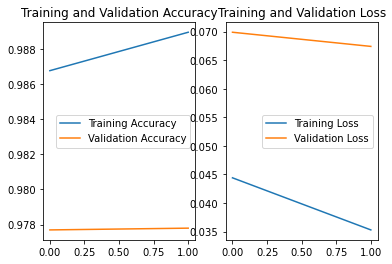

In [8]:
from matplotlib import pyplot as plt
print(model.trainable_variables)
file = open('./weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### application

1/1 [==============================] - 0s 114ms/step


[0]


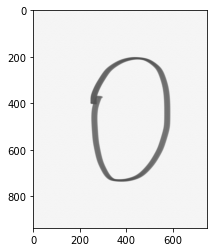

1/1 [==============================] - 0s 23ms/step


[1]


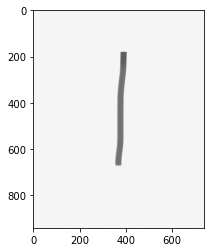

1/1 [==============================] - 0s 20ms/step


[2]


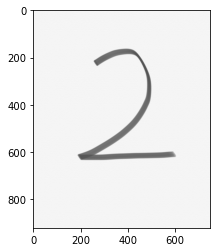

1/1 [==============================] - 0s 52ms/step


[3]


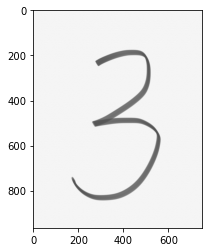

1/1 [==============================] - 0s 26ms/step


[4]


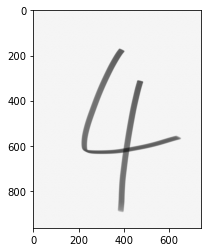

1/1 [==============================] - 0s 44ms/step


[5]


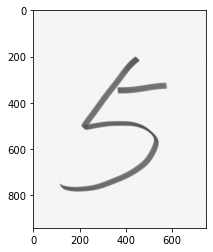

1/1 [==============================] - 0s 20ms/step


[6]


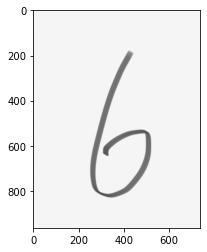

1/1 [==============================] - 0s 18ms/step


[7]


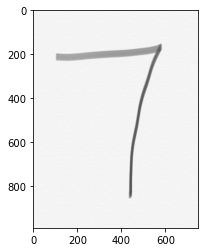

1/1 [==============================] - 0s 21ms/step


[8]


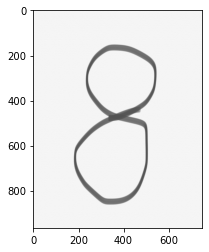

1/1 [==============================] - 0s 19ms/step


[9]


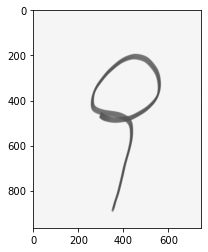

In [10]:
model_save_path = './checkpoint/mnist.ckpt'
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.load_weights(model_save_path)
preNum = 10

for i in range(preNum):
    image_path = str(i)+".png"
    img = Image.open(image_path)

    image = plt.imread(image_path)
    plt.set_cmap('gray')
    plt.imshow(image)

    img = img.resize((28, 28), Image.ANTIALIAS)
    img_arr = np.array(img.convert('L'))

    for i in range(28):
        for j in range(28):
            if img_arr[i][j] < 200:
                img_arr[i][j] = 255
            else:
                img_arr[i][j] = 0

    img_arr = img_arr / 255.0
    x_predict = img_arr[tf.newaxis, ...]
    result = model.predict(x_predict)
    pred = tf.argmax(result, axis=1)

    print('\n')
    tf.print(pred)

    plt.pause(1)
    plt.close()